**Name: Nidhi Rajkumar Saini**

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray

import tensorflow as tf
import tensorflow.keras.backend as k
from tensorflow.keras.layers import Activation
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback
from keras.utils import np_utils

from sklearn.cluster import KMeans

In [ ]:
def get_random_pixels(percent = 0.8):
  numPix = x_bird.shape[0] * x_bird.shape[1] * x_bird.shape[2]
  numRandom = int(numPix * percent)
  linearIdx = np.random.choice(numPix, numRandom)
  imgIdx = [idx // 1024 for idx in linearIdx]
  rowIdx = [idx % 1024 // 32 for idx in linearIdx]
  colIdx = [idx % 1024 % 32 for idx in linearIdx]
  pixIdx = (imgIdx, rowIdx, colIdx)
  select_pix = x_bird[pixIdx]
  return select_pix

In [ ]:
def split_data(x, y, num_train):
  x_train = x[:num_train]
  x_test = x[num_train:]
  onehot = np_utils.to_categorical(y) # Using predictions from suggested colors
  onehot = onehot.reshape((len(x), 4096)) # 4096 -> 32*32*4
  y_train = onehot[:num_train].reshape((-1, 4096))
  y_test = onehot[num_train:].reshape((-1, 4096))
  return x_train, x_test, y_train, y_test


# Load CIFAR 10 Data

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

## From the train and test dataset, extract the class birds.

In [ ]:
# get the index of bird samples
bird_train_idx, _ = np.where(y_train == 2)
bird_test_idx, _ = np.where(y_test == 2)

# get samples
x_train_bird, y_train_bird = x_train[bird_train_idx], y_train[bird_train_idx]
x_test_bird, y_test_bird = x_test[bird_test_idx], y_test[bird_test_idx]

x_bird = np.concatenate([x_train_bird, x_test_bird])
y_bird = np.concatenate([y_train_bird, y_test_bird])

print(x_bird.shape)

(6000, 32, 32, 3)


## Choose at least 10% of the pixels randomly. It is strongly recommended that you choose a large number or all of the pixels. You will have between P = 614400 and P = 6144000 pixels. Each pixel is an RGB vector with three elements. (Taking 80%)

In [ ]:
select_pix = get_random_pixels()

## Run k-means clustering on the P vectors using k = 4.

In [ ]:

kmeans = KMeans(n_clusters=4, random_state=0).fit(select_pix) 
centers = kmeans.cluster_centers_.astype(np.uint8())
print("Cluster Centers:")
centers

Cluster Centers:


array([[109, 109,  82],
       [207, 212, 212],
       [ 49,  50,  38],
       [156, 156, 136]], dtype=uint8)

In [ ]:
kmeans.cluster_centers_ = np.array([[0,0,128],
                                    [230,25,75],
                                    [170,255,195],
                                    [55,255,255]])

suggest_kcolor_birds = x_bird.reshape((-1, 3)) # Flatten
predict = kmeans.predict(suggest_kcolor_birds)

for i in range(suggest_kcolor_birds.shape[0]):
  suggest_kcolor_birds[i] = np.copy(kmeans.cluster_centers_[predict[i]])

suggest_kcolor_birds = np.reshape(suggest_kcolor_birds, x_bird.shape)

Tetracolored:


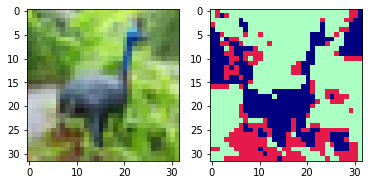

In [ ]:
print("Tetracolored:")
fig, axes = plt.subplots(1, 2)
axes[0].imshow(x_bird[0])
axes[1].imshow(suggest_kcolor_birds[0])
plt.show()

## Use any tool (e.g., openCV or scikit-learn) to obtain grayscale 32 × 32 × 1 images from the original 32 × 32 × 3 images. The grayscale images are inputs of your network.

In [ ]:
gray_birds = np.expand_dims(rgb2gray(x_bird), axis=-1)

Gray Birds:


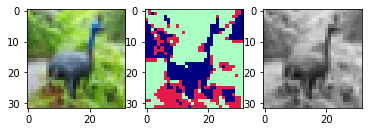

In [ ]:
print("Gray Birds:")
fig, axes = plt.subplots(1, 3)
axes[0].imshow(x_bird[0])
axes[1].imshow(suggest_kcolor_birds[0])
axes[2].imshow(np.stack((gray_birds[0, :, :, 0], ) * 3, axis=-1), cmap='gray')
plt.show()

## Set up a deep convolutional neural network

In [ ]:
num_train = 4800
cnn_train_x, cnn_test_x, cnn_train_y, cnn_test_y = split_data(gray_birds, predict, num_train)

In [ ]:
model = Sequential()
# convolutional layers
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', 
                  input_shape=(32,32,1), activation='relu',
                  kernel_initializer='he_normal'))
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', 
                  activation='relu', kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5,5), padding='same', 
                  activation='relu', kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2, 2)))    
model.add(Dropout(0.25))
# MLP layers
model.add(Flatten())
model.add(Dense(8192, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Activation('softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 64)          0

In [ ]:
test_loss = []
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
      # record a test loss
        scores = self.model.evaluate(cnn_test_x, cnn_test_y, verbose=1)
        test_loss.append(scores)
        checkpointer = ModelCheckpoint(filepath='CNNcheckpoints\weights.{epoch:02d}-{val_loss:.2f}.hdf5', 
                                       monitor='val_loss', mode='min', 
                                       verbose=0, save_best_only=True)

In [ ]:
# fit the model
model.compile(loss='binary_crossentropy', optimizer='adam')
history = model.fit(cnn_train_x, cnn_train_y, 
                    validation_split=0.1, batch_size=32, 
                    epochs=50, verbose=1, callbacks=[MyCallback()])

Epoch 1/50
38/38 [==============================] - 0s 6ms/step - loss: 0.6931
Epoch 2/50
38/38 [==============================] - 0s 4ms/step - loss: 0.6929
Epoch 3/50
38/38 [==============================] - 0s 4ms/step - loss: 0.6903
Epoch 4/50
38/38 [==============================] - 0s 4ms/step - loss: 0.6859
Epoch 5/50
38/38 [==============================] - 0s 4ms/step - loss: 0.6838
Epoch 6/50
38/38 [==============================] - 0s 4ms/step - loss: 0.6784
Epoch 7/50
38/38 [==============================] - 0s 5ms/step - loss: 0.6759
Epoch 8/50
38/38 [==============================] - 0s 4ms/step - loss: 0.6726
Epoch 9/50
38/38 [==============================] - 0s 4ms/step - loss: 0.6724
Epoch 10/50
38/38 [==============================] - 0s 4ms/step - loss: 0.6693
Epoch 11/50
38/38 [==============================] - 0s 4ms/step - loss: 0.6677
Epoch 12/50
38/38 [==============================] - 0s 5ms/step - loss: 0.6702
Epoch 13/50
38/38 [==============================

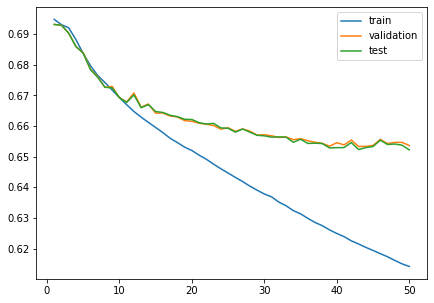

In [ ]:
# plot loss curves
epoch = 50
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

fig, axes = plt.subplots(figsize=(7, 5))
axes.plot(range(1, epoch + 1), train_loss, label='train')
axes.plot(range(1, epoch + 1), valid_loss, label='validation')
axes.plot(range(1, epoch + 1), test_loss, label='test')
axes.legend()
plt.show()

In [ ]:
cnn_predict_y = model.predict(cnn_test_x[:10])
cnn_predict_y = np.reshape(cnn_predict_y, (10, 32, 32, 4))
cnn_predict_y = np.argmax(cnn_predict_y, axis=-1)
cnn_predict_y = kmeans.cluster_centers_[cnn_predict_y]
print(cnn_predict_y.shape)

(10, 32, 32, 3)


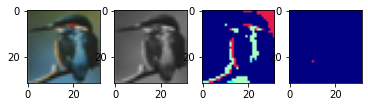

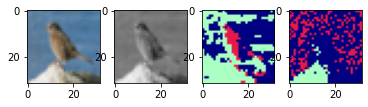

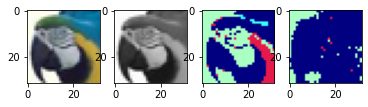

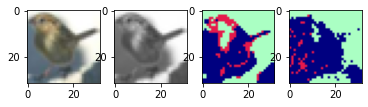

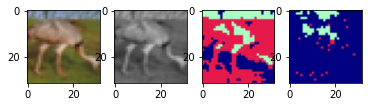

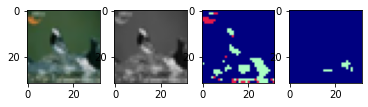

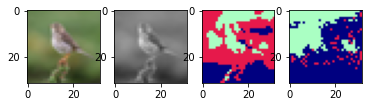

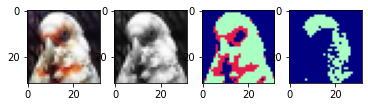

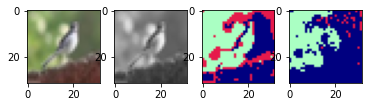

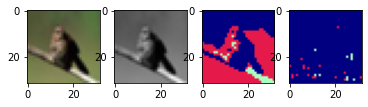

In [ ]:
for i in range(10):
  fig, axes = plt.subplots(1, 4)
  axes[0].imshow(x_bird[num_train+i])
  axes[1].imshow(np.stack((gray_birds[num_train+i, :, :, 0], ) * 3, axis=-1), cmap='gray')
  axes[2].imshow(suggest_kcolor_birds[num_train+i])
  axes[3].imshow(cnn_predict_y[i])
  plt.show()

**References:**<br>https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/<br>https://lukemelas.github.io/image-colorization.html